In [1]:
import os
import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl

# /n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit  

In [2]:
import functools3 as p3

In [3]:
#set_plot_params()
visual_areas, area_colors = p3.set_threecolor_palette() 

In [4]:
%matplotlib notebook

In [5]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

# Load source data

In [6]:
src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')
dfns = glob.glob(os.path.join(src_data_dir, '*.pkl'))
dfns

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/results.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/R.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC_single.pkl']

In [7]:
src_datafile = os.path.join(src_data_dir, dfns[0])
src_datafile

'/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl'

In [8]:
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# D.keys()

DATA = D['DATA']
# sdata = D['sdata']
SDF = D['SDF']
selective_df = D['selective_df']
del D

In [9]:
DATA[DATA['visual_area']=='Li']['datakey'].unique()


array(['20190327_JC073_fov1', '20191018_JC113_fov1',
       '20190319_JC067_fov1', '20190322_JC073_fov1',
       '20190315_JC070_fov1', '20190607_JC091_fov1',
       '20190602_JC091_fov1', '20190321_JC070_fov1',
       '20190614_JC091_fov1', '20190612_JC099_fov1',
       '20190314_JC070_fov1', '20190617_JC099_fov1',
       '20190316_JC070_fov1', '20191111_JC120_fov1',
       '20190609_JC099_fov1', '20190320_JC067_fov1',
       '20190422_JC076_fov1', '20190606_JC091_fov1',
       '20191105_JC117_fov1'], dtype=object)

In [10]:
DATA.shape

(4542744, 7)

In [11]:
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]


# Params

In [12]:
#### Set params
sigmoid='gauss'
allow_negative=False
single_eff=True

sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
param = 'morphlevel'
 
class_a=0
class_b=106

criterion = 0.7

fitopts = p3.default_options()

gauss_reverse


# Output dir

In [13]:
# output dir
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves', 'psignifit', 'split_pupil', sigmoid_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse


['aggr_param_avgs_split_conds__lineplots.svg',
 'aggr_param_avgs_split_conds__shuffle-v-true.svg',
 'avg_curves_aggr_cells.svg',
 'avg_params_by_arousal_shuffcond.svg']

In [14]:
arousal_colors = {'high': 'm', 'low': 'c'}
dashes=['', (1, 1)]
markers={True:'o', False:'o'}

parnames = ['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

# Load main AUC

In [15]:

AUC = p3.load_aggregate_AUC(param=param, allow_negative=allow_negative,
                          selective_only=False, selective_df=None, single_eff=single_eff)

   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.590000           0  10.0  106        30   
1   113        1      1  0.543333          14  10.0  106        30   
2   113        2      2  0.596667          27  10.0  106        30   
3   113        3      3  0.523333          40  10.0  106        30   
4   113        4      4  0.644444          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  
... reversing


In [17]:
dk = '20191006_JC110_fov1'

In [81]:
#### Only select cells with min. response > crit
criterion = 0.7


sdf=SDF[dk].copy()
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]


#pAUC = AUC[(AUC['morphlevel'].isin(anchors_)) & (AUC['AUC']>=criterion)].copy()
pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
                  if g['AUC'].max()>=criterion])

print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               241   241
Lm               485   485
V1               684   684


#### test loading

In [80]:
#### Load AUC ITERS
va='V1'
dk ='20190507_JC083_fov1'
traceid_dir = p3.get_tracedir_from_datakey(dk)
auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'AUC__*.pkl'))
print(len(auc_outfile))

with open(auc_outfile[0], 'rb') as f:
    auc_fov_iters = pkl.load(f)
    

1


In [22]:
# sig = 'gauss'
# opts = dict()
# opts['sigmoidName'] = sig
# opts['expType'] = '2AFC' #'2AFC'
# opts['threshPC'] = 0.5
# allow_negative=True

# fiter = auc_iter_r[auc_iter_r['iteration']==2].groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#         .apply(group_fit_psignifit, opts, allow_negative=allow_negative)


# Load mean AUCs

In [82]:
def load_split_pupil_AUC(dk, param='morphlevel', midp=53, allow_negative=True,
                  single_eff=True, exclude=['20190314_JC070_fov1'],
                  anchors_=[0, 14, 92, 106]):
 

    fname = 'mean_aucs_single' if single_eff else 'mean_aucs'
    traceid_dir = p3.get_tracedir_from_datakey(dk)
    auc_file = os.path.join(traceid_dir, 'neurometric', 'split_pupil','%s.pkl' % fname)
    with open(auc_file, 'rb') as f:
        auc_fov = pkl.load(f)
    
    return auc_fov

In [332]:
def plot_aucs_by_size_split_pupil(auc_r, param='morphlevel', 
                                  arousal_colors = {'high': 'm', 'low': 'c'},
                                  dashes=['', (1, 1)], markers={True:'o', False:'o'}):
    
    if param=='morphlevel':
        xticks = np.linspace(0, 100, 3)
    else:
        xticks = np.linspace(0, 1, 3)
    yticks = np.linspace(0.2, 1, 3)
    
    sizes= sorted(auc_r['size'].unique())
    eff = int(auc_r['Eff'].unique())
    fig, axn = pl.subplots(1,len(sizes), figsize=(10,3.5), sharex=True, sharey=True)
    for ax, (sz, sg) in zip(axn.flat, auc_r[auc_r['Eff']==eff].groupby(['size'])):
        sns.lineplot(x=param, y='AUC', hue='arousal', data=sg, ax=ax,
                    style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
        ax.legend_.remove()
        ax.set_title('Sz %i' % sz, loc='left', fontsize=8)
        
        ax.set_ylim([yticks[0], yticks[-1]+0.1])
        ax.set_yticks(yticks)
        ax.set_xticks(xticks)
        
    sns.despine(trim=True, offset=8)

    axn[-1].legend(bbox_to_anchor=(1,1.3), loc='lower right', ncol=2)
    fig.text(0.01, 0.9, 'Cell %i, %s, %s (Eff=%i)' % (rid, dk, va, eff), fontsize=16)
    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.25, top=0.6, wspace=0.3)

    return fig

In [333]:
def fits_from_params(rfits, opts=None, npoints=50):
    # Do fits
    if opts is None:
        opts = p3.default_options()

    fh = getSig.getSigmoidHandle(opts)
    fitvs = rfits.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
                .apply(p3.get_fit_values, fh, xmin=0, xmax=1, npoints=npoints).reset_index(drop=True)

    return fitvs



def plot_fits_by_size_split_pupil(fitvs, auc_r=None, opts=None, npoints=50, 
                                  plot_data=True, param='morphlevel', markersize=5,
                                arousal_colors = {'high': 'm', 'low': 'c'},
                                  dashes=['', (1, 1)], markers={True:'o', False:'o'}):

    if param=='morphlevel':
        xticks = np.linspace(0, 1, 3)
    else:
        xticks = np.linspace(0, 1, 3)
    yticks = np.linspace(0.2, 1, 3)
    
    sizes= sorted(fitvs['size'].unique())
    if plot_data:
        assert auc_r is not None, "No data provided, auc_r should not be None."
        max_x = float(auc_r[param].max())
        auc_r[param] = auc_r[param]/max_x

    fig, axn = pl.subplots(1,len(sizes), figsize=(10,3.5), sharex=True, sharey=True)
    for ax, (sz, fv) in zip(axn.flat, fitvs.groupby(['size'])):
        sns.lineplot(x='x', y='fitv', data=fv, ax=ax,
                     hue='arousal', palette=arousal_colors,
                     style_order=[True, False], dashes=dashes, style='true_labels')
    
        if plot_data:
            assert auc_r is not None, "No data provided, auc_r should not be None."
            auc_ = auc_r[auc_r['size']==sz]
            sns.lineplot(x=param, y='AUC', data=auc_[auc_.true_labels], ax=ax,
                            hue='arousal', palette=arousal_colors,
                            style='true_labels', style_order=[True, False], dashes=dashes, lw=0.,
                            sizes=[markersize,markersize], markers=markers)
        ax.legend_.remove()
        ax.set_title('Sz %i' % sz, loc='left', fontsize=8)
        
        ax.set_ylim([yticks[0], yticks[-1]+0.1])
        ax.set_yticks(yticks)
        ax.set_xticks(xticks)
        
    sns.despine(trim=True, offset=8)

    #axn[-1].legend(bbox_to_anchor=(1,1.3), loc='lower right', ncol=2)
    fig.text(0.01, 0.9, 'Cell %i, %s, %s (Eff=%i)' % (rid, dk, va, eff), fontsize=16)
    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.25, top=0.6, wspace=0.3)
    
    
    p3.crop_legend_labels(axn[-1], n_hues=6, bbox_to_anchor=(1,1.3), 
                          loc='lower right', ncol=2, fontsize=8)

    return fig

In [334]:

va='V1'
dk = '20190507_JC083_fov1'
auc_fov = load_split_pupil_AUC(dk, single_eff=single_eff, allow_negative=allow_negative)
auc_fov.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
0          V1  20190507_JC083_fov1     1    high        False           0   
1          V1  20190507_JC083_fov1     1    high        False           0   
2          V1  20190507_JC083_fov1     1    high        False           0   
3          V1  20190507_JC083_fov1     1    high        False           0   
4          V1  20190507_JC083_fov1     1    high        False           0   

   size  Eff  index       AUC  n_trials  iteration  n_chooseB  
0  10.0  106  39.60  0.468250       5.0       49.5   2.341250  
1  20.0  106  40.67  0.441429       7.0       49.5   3.090000  
2  30.0  106  41.74  0.522302       7.0       49.5   3.656111  
3  40.0  106  42.81  0.408889       7.0       49.5   2.862222  
4  50.0  106  43.88  0.406750       5.0       49.5   2.033750

In [335]:
rid=8

auc_r = auc_fov[auc_fov['cell']==rid]
auc_r.shape

(180, 13)

In [339]:
basedir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves', 'psignifit', 'split_pupil')



In [340]:
curr_dst_dir = os.path.join(basedir, 'examples')

<IPython.core.display.Javascript object>


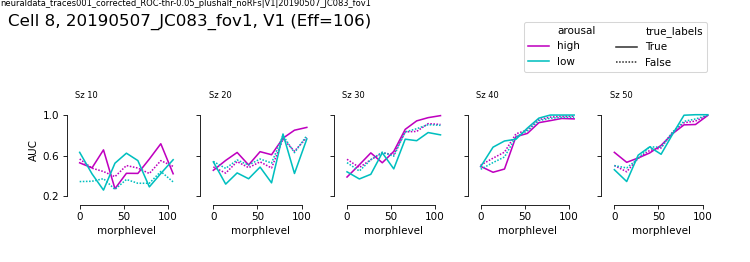

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples V1_20190507_JC083_fov1_rid008_AUC


In [342]:
fig = plot_aucs_by_size_split_pupil(auc_r, param=param)
p3.label_figure(fig, curr_id)

figname = '%s_%s_rid%03d_AUC' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


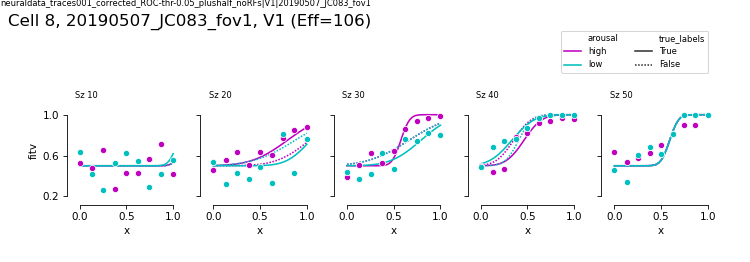

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples V1_20190507_JC083_fov1_rid008_FIT


In [343]:
plot_data=True

rfits = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) & (roifits['cell']==rid)]
fitvs = fits_from_params(rfits, opts=None)


markers={True:'o', False:'o'}

fig = plot_fits_by_size_split_pupil(fitvs, auc_r=auc_r, opts=None, npoints=50, 
                                  plot_data=True, param='morphlevel', markersize=20)

p3.label_figure(fig, curr_id)

figname = '%s_%s_rid%03d_FIT' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [344]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples'

# Aggregate AUC, split_pupil

In [ ]:
# f
#     auc_fov = load_split_pupil_AUC(dk, single_eff=single_eff, allow_negative=allow_negative)


# Load split pupil fits

In [21]:
from psignifit import getSigmoidHandle as getSig


In [22]:
print(sigmoid_dir)

roi_fit_fns = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs_static', 
                                  'traces', 'traces001*', 'neurometric', 'split_pupil', 
                                  'fits', sigmoid_dir, 'meanAUC_*.pkl'))
len(roi_fit_fns)

gauss_reverse


2632

In [23]:
r_ = []
for rfn in roi_fit_fns:

    with open(rfn, 'rb') as f:
        rd = pkl.load(f)
    #print( rdict.keys())
    if isinstance(rd, dict):
        print(rfn)
        continue
    #r_.extend([v for k, v in rdict.items()])
    r_.append(rd)
    
roifits = pd.concat(r_, axis=0)



# missing={}
# r_=[]
# for (va, dk), g in pAUC.groupby(['visual_area', 'datakey']):
#     #print(va, dk)
#     curr_fits, curr_miss = p3.load_fitparams(dk, roi_list=g['cell'].unique(),
#                                  allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=True,
#                                  return_dicts=False, return_missing=True)
#     r_.append(curr_fits)
#     if len(curr_miss)>0:
#         missing[(va, dk)] = curr_miss
    
# roifits = pd.concat(r_).reset_index(drop=True)


In [24]:
roifits[roifits['threshold']>2]


Empty DataFrame
Columns: [threshold, width, lambda, gamma, eta, slope, thr, visual_area, datakey, cell, size, Eff, arousal, true_labels]
Index: []

In [164]:
# dk ='20191006_JC110_fov1'
# va='V1'
# rfits, missing_ = p3.load_fitparams(dk, roi_list=None, allow_negative=True,
#                   split_pupil=True, sigmoid='gauss', return_dicts=False, return_missing=True)

In [165]:
# traceid_dir = p3.get_tracedir_from_datakey(dk)
# rfn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'fits', sigmoid_dir, 'meanAUC_*.pkl'))[0]

# with open(rfn, 'rb') as f:
#     rd = pkl.load(f)
# rd.keys()

In [25]:
roifits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               428   428
Lm              1056  1056
V1              1148  1148

In [26]:
va='V1'
dk = '20191006_JC110_fov1'
v1 = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) 
        & (~roifits.true_labels) & (roifits.arousal=='high')]

v2 = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) 
        & (~roifits.true_labels) & (roifits.arousal=='low')]
np.where(v1['threshold'].values!=v2['threshold'].values)

(array([  0,   1,   2,   3,   4,   5,   6,  10,  11,  12,  13,  15,  18,
         19,  20,  25,  26,  27,  30,  33,  35,  37,  38,  40,  41,  43,
         44,  45,  46,  50,  51,  53,  54,  55,  56,  57,  60,  62,  63,
         65,  66,  67,  68,  69,  70,  74,  75,  79,  80,  81,  82,  83,
         85,  87,  88,  89,  90,  91,  95,  96,  97,  98,  99, 100, 102,
        103, 105, 108, 110, 111, 112, 115, 117, 119, 120, 121, 122, 124,
        125, 127, 128, 129, 130, 131, 134, 135, 136, 140, 143, 145, 146,
        147, 150, 153, 155, 158, 160, 162, 163, 165, 166, 167, 168, 170,
        175, 178, 180, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196,
        197, 199, 200, 201, 203, 205, 207, 210, 211, 212, 213, 215, 216,
        217, 218, 219, 220, 221, 223, 225, 226, 227, 228, 229, 230, 232,
        233, 235, 236, 237, 240, 245, 248, 250, 251, 252, 253, 254, 255,
        258, 260, 261, 262, 264, 265, 266, 267, 270, 271, 272, 273, 274,
        275, 277, 278, 280, 281, 283, 284, 285, 286

In [27]:
v1

threshold     width        lambda  gamma           eta     slope  \
61    1.072908  0.244253  2.081596e-07    0.5  3.965469e-08  2.686562   
61    1.099343  0.242435  1.363723e-09    0.5  7.993276e-06  2.706713   
61    1.056973  0.244652  2.376213e-04    0.5  7.551355e-08  2.680909   
61    1.093626  0.243784  2.733759e-08    0.5  3.122183e-08  2.691738   
61    1.094928  0.242650  3.107991e-07    0.5  4.972582e-06  2.704316   
..         ...       ...           ...    ...           ...       ...   
301   1.115854  0.241960  4.659255e-06    0.5  5.813632e-08  2.711998   
301   1.097949  0.241799  5.146017e-08    0.5  6.091432e-06  2.713828   
301   1.098668  0.242639  3.827987e-08    0.5  3.111390e-07  2.704439   
301   1.093626  0.243784  2.733759e-08    0.5  3.122183e-08  2.691738   
301   1.094628  0.242899  1.132221e-07    0.5  1.286722e-06  2.701537   

          thr visual_area              datakey  cell  size  Eff arousal  \
61   1.072908          V1  20191006_JC110_fov1    61  10.0  106    high   
61   1.099343          V1  20191006_JC110_fov1    61  20.0  106    high   
61   1.057017          V1  20191006_JC110_fov1    61  30.0  106    high   
61   1.093626          V1  20191006_JC110_fov1    61  40.0  106    high   
61   1.094928          V1  20191006_JC110_fov1    61  50.0  106    high   
..        ...         ...                  ...   ...   ...  ...     ...   
301  1.115855          V1  20191006_JC110_fov1   301  10.0    0    high   
301  1.097949          V1  20191006_JC110_fov1   301  20.0    0    high   
301  1.098668          V1  20191006_JC110_fov1   301  30.0    0    high   
301  1.093626          V1  20191006_JC110_fov1   301  40.0    0    high   
301  1.094628          V1  20191006_JC110_fov1   301  50.0    0    high   

     true_labels  
61         False  
61         False  
61         False  
61         False  
61         False  
..           ...  
301        False  
301        False  
301        False  
301        False  
301        False  

[380 rows x 14 columns]

In [28]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse'

In [29]:
# onefit = pd.concat([g for r, g in rfits.groupby(['visual_area', 'datakey', 'cell']) \
#                 if len(g['Eff'].unique())==1])
# onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

onefit = pd.concat([g for r, g in roifits.groupby(['visual_area', 'datakey', 'cell']) \
                if len(g[g.true_labels]['Eff'].unique())==1])
onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


print(onefit[onefit['Eff']==0][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count())
print(onefit[onefit['Eff']==106][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               196   196
Lm               650   650
V1               814   814
             datakey  cell
visual_area               
Li               231   231
Lm               406   406
V1               334   334


In [30]:
# roifits[(roifits.visual_area=='Li') & (roifits.datakey=='20190602_JC091_fov1')].round(5)
roifits[(roifits.visual_area=='V1') & (roifits.datakey=='20191006_JC110_fov1')].round(5)

threshold    width  lambda  gamma      eta     slope       thr  \
61     1.07291  0.24425  0.0000    0.5  0.00000  2.686562  1.072908   
61     1.11548  0.24197  0.0000    0.5  0.00033  2.711965   1.11548   
61     1.07339  0.24482  0.0002    0.5  0.00000  2.679276   1.07343   
61     1.07496  0.24434  0.0000    0.5  0.00000  2.685564  1.074962   
61     1.09934  0.24243  0.0000    0.5  0.00001  2.706713  1.099343   
..         ...      ...     ...    ...      ...       ...       ...   
301    1.09363  0.24378  0.0000    0.5  0.00000  2.691738  1.093626   
301    1.09463  0.24290  0.0000    0.5  0.00000  2.701537  1.094628   
301    1.09363  0.24378  0.0000    0.5  0.00000  2.691738  1.093626   
301    1.09463  0.24290  0.0000    0.5  0.00000  2.701537  1.094628   
301    1.09552  0.24289  0.0000    0.5  0.00000  2.701638  1.095522   

    visual_area              datakey  cell  size  Eff arousal  true_labels  
61           V1  20191006_JC110_fov1    61  10.0  106    high        False  
61           V1  20191006_JC110_fov1    61  10.0  106    high         True  
61           V1  20191006_JC110_fov1    61  10.0  106     low        False  
61           V1  20191006_JC110_fov1    61  10.0  106     low         True  
61           V1  20191006_JC110_fov1    61  20.0  106    high        False  
..          ...                  ...   ...   ...  ...     ...          ...  
301          V1  20191006_JC110_fov1   301  40.0    0     low         True  
301          V1  20191006_JC110_fov1   301  50.0    0    high        False  
301          V1  20191006_JC110_fov1   301  50.0    0    high         True  
301          V1  20191006_JC110_fov1   301  50.0    0     low        False  
301          V1  20191006_JC110_fov1   301  50.0    0     low         True  

[1520 rows x 14 columns]

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


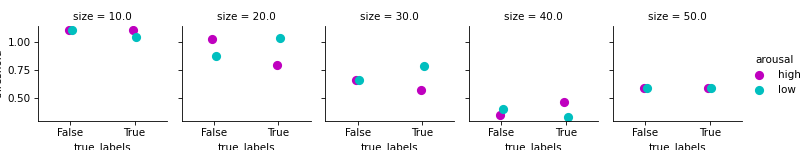

In [79]:
va='V1'
dk = '20190507_JC083_fov1'
rid =8 
rfits = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) & (roifits['cell']==rid)].round(5)

# fig, ax = pl.subplots()
sns.catplot(x='true_labels', y='threshold', data=rfits, ax=ax, kind='point', col='size', height=2,
              hue='arousal', palette=arousal_colors, join=False, dodge=True)

<IPython.core.display.Javascript object>


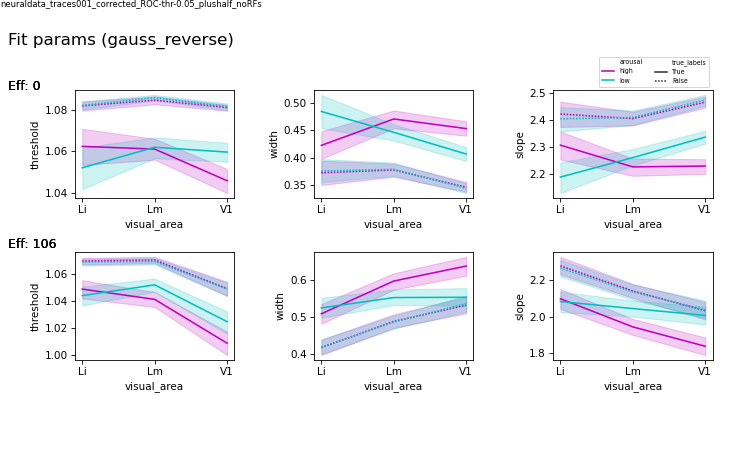

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse aggr_param_avgs_split_conds__lineplots


In [31]:
par = 'threshold'

plotparams = ['threshold', 'width', 'slope'] #, 'thr', 'width', 'slope']
for p in plotparams:
    onefit[p] = onefit[p].astype(float)
    
fig, axn = pl.subplots(2, len(plotparams), figsize=(10,6))

for pi, par in enumerate(plotparams):
    eff=0
    ax=axn[0, pi]
    fig.text(0.01, 0.8, 'Eff: %i' % eff, fontsize=12)
    sns.lineplot(x='visual_area', y=par, data=onefit[onefit['Eff']==0].dropna(), ax=ax,
                 hue='arousal', style='true_labels', style_order=[True, False], dashes=dashes,
                palette=arousal_colors) #onefit[par]
    ax.legend_.remove()
    
    ax=axn[1, pi]
    eff=106
    fig.text(0.01, 0.45, 'Eff: %i' % eff, fontsize=12)
    sns.lineplot(x='visual_area', y=par, data=onefit[onefit['Eff']==eff].dropna(), ax=ax,
             hue='arousal', style='true_labels', style_order=[True, False], dashes=dashes,
                palette=arousal_colors) #onefit[par]
    ax.legend_.remove()
    
axn[0, len(plotparams)-1].legend(bbox_to_anchor=(1, 1), loc='lower right', fontsize=6, ncol=2)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Fit params (%s)' % sigmoid_dir, fontsize=16)
figname = 'aggr_param_avgs_split_conds__lineplots' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

<IPython.core.display.Javascript object>


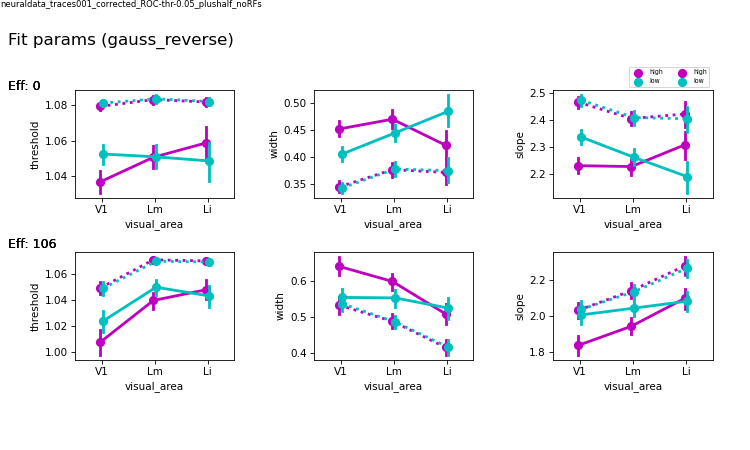

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse aggr_param_avgs_split_conds__shuffle-v-true


In [32]:

plotparams = ['threshold', 'width', 'slope'] #, 'thr', 'width', 'slope']
  
fig, axn = pl.subplots(2, len(plotparams), figsize=(10,6))

for pi, par in enumerate(plotparams):
    ax=axn[0, pi]
    eff=0
    df = onefit[onefit['Eff']==eff]
    fig.text(0.01, 0.8, 'Eff: %i' % eff, fontsize=12)
    sns.pointplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True)

    sns.pointplot(x='visual_area', y=par, data=df[~df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True, linestyles=':')
    ax.legend_.remove()
    ax=axn[1, pi]
    eff=106
    df = onefit[onefit['Eff']==eff]
    fig.text(0.01, 0.45, 'Eff: %i' % eff, fontsize=12)
    sns.pointplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True)

    sns.pointplot(x='visual_area', y=par, data=df[~df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True, linestyles=':')
    
    ax.legend_.remove()
axn[0, len(plotparams)-1].legend(bbox_to_anchor=(1, 1), loc='lower right', fontsize=6, ncol=2)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)



p3.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Fit params (%s)' % sigmoid_dir, fontsize=16)
figname = 'aggr_param_avgs_split_conds__shuffle-v-true' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)


In [74]:
onefit

threshold     width        lambda  gamma           eta     slope  \
29    1.094928  0.242650  3.107991e-07    0.5  4.972582e-06  2.704316   
29    1.146181  0.240082  4.197750e-07    0.5  3.288351e-05  2.733233   
29    1.094628  0.242899  1.132221e-07    0.5  1.286722e-06  2.701537   
29    1.007137  0.242371  1.603772e-08    0.5  1.625986e-04  2.707426   
29    1.093626  0.243784  2.733759e-08    0.5  3.122183e-08  2.691738   
..         ...       ...           ...    ...           ...       ...   
390   0.149499  0.265020  2.115925e-01    0.5  1.588627e-08  0.770037   
390   1.094628  0.242899  1.132221e-07    0.5  1.286722e-06  2.701537   
390   1.008656  1.559775  7.642074e-09    0.5  2.299456e-08  0.420703   
390   1.045324  0.244874  4.648704e-07    0.5  3.201598e-07  2.679749   
390   1.096145  0.242535  2.526314e-04    0.5  6.642786e-09  2.704227   

          thr visual_area              datakey  cell  size  Eff arousal  \
29   1.094928          Li  20190316_JC070_fov1    29  10.0  106    high   
29   1.146181          Li  20190316_JC070_fov1    29  10.0  106    high   
29   1.094628          Li  20190316_JC070_fov1    29  10.0  106     low   
29   1.007137          Li  20190316_JC070_fov1    29  10.0  106     low   
29   1.093626          Li  20190316_JC070_fov1    29  20.0  106    high   
..        ...         ...                  ...   ...   ...  ...     ...   
390  0.239044          V1  20191006_JC110_fov1   390  40.0  106     low   
390  1.094628          V1  20191006_JC110_fov1   390  50.0  106    high   
390  1.008656          V1  20191006_JC110_fov1   390  50.0  106    high   
390  1.045324          V1  20191006_JC110_fov1   390  50.0  106     low   
390  1.096192          V1  20191006_JC110_fov1   390  50.0  106     low   

     true_labels  
29         False  
29          True  
29         False  
29          True  
29         False  
..           ...  
390         True  
390        False  
390         True  
390        False  
390         True  

[52620 rows x 14 columns]

In [41]:
mean_fits = onefit.groupby(['visual_area', 'datakey', 'cell', 'arousal', 'true_labels']).mean().reset_index()
mean_fits[mean_fits['threshold']<=1]

<IPython.core.display.Javascript object>


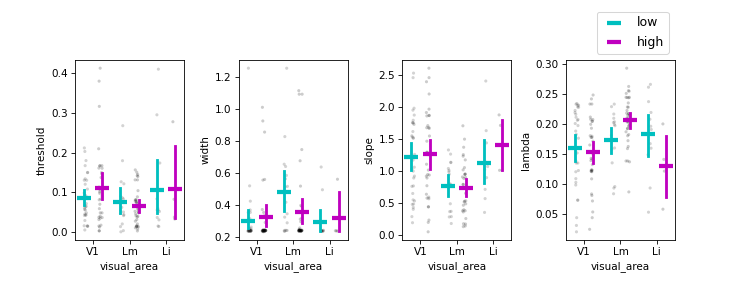

In [73]:
#df = mean_fits.copy() #
#df = mean_fits[(mean_fits['threshold']<=1) & (mean_fits['lambda']>0)]
df = onefit[(onefit['threshold']<=1) & (onefit['threshold']>=0) & (onefit['lambda']>0.01)]

plot_params = ['threshold', 'width', 'slope', 'lambda']

par='threshold'
fig, axn = pl.subplots(1, len(plot_params), figsize=(10,4))

for ax, par in zip(axn.flat, plot_params):
    sns.pointplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax,
                  hue='arousal', palette=arousal_colors, dodge=0.5, size=2, join=False, zorder=-1,
                 markers='_', scale=2, order=visual_areas)
    
    sns.stripplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax,
                  hue='arousal', color='k', dodge=0.5, size=3, zorder=-1, alpha=0.2,
                 order=visual_areas)
    ax.legend_.remove()

p3.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1, 1.))

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5, top=0.8)

In [171]:

va='V1'
dk='20191006_JC110_fov1'
curr_fits = onefit[(onefit.visual_area==va) & (onefit.datakey==dk)]
pass_cells = [r for r, g in curr_fits.groupby(['cell']) if len(g["Eff"].unique())==1]
# pass_cells

[4,
 5,
 6,
 11,
 12,
 24,
 33,
 38,
 46,
 55,
 61,
 76,
 77,
 79,
 85,
 86,
 100,
 104,
 106,
 107,
 108,
 116,
 118,
 121,
 128,
 131,
 133,
 140,
 141,
 152,
 153,
 167,
 170,
 172,
 175,
 178,
 182,
 187,
 198,
 215,
 216,
 223,
 225,
 228,
 230,
 232,
 235,
 240,
 242,
 243,
 248,
 252,
 255,
 267,
 275,
 276,
 279,
 285,
 298,
 301,
 302,
 304,
 305,
 307,
 310,
 325,
 336,
 337,
 338,
 353,
 354,
 355,
 364,
 380,
 383,
 390]

In [172]:
curr_fits[curr_fits['Eff'].isin([0, 106])]['cell'].unique()

array([  4,   5,   6,  11,  12,  24,  33,  38,  46,  55,  61,  76,  77,
        79,  85,  86, 100, 104, 106, 107, 108, 116, 118, 121, 128, 131,
       133, 140, 141, 152, 153, 167, 170, 172, 175, 178, 182, 187, 198,
       215, 216, 223, 225, 228, 230, 232, 235, 240, 242, 243, 248, 252,
       255, 267, 275, 276, 279, 285, 298, 301, 302, 304, 305, 307, 310,
       325, 336, 337, 338, 353, 354, 355, 364, 380, 383, 390])

In [232]:
parnames = ['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

In [233]:
# fitpars = onefit[(onefit['threshold']<=106) & (onefit['threshold']>=0)]
#              & (onefit['width']<=106*1.5) & (onefit['lambda']>0)].copy()


fitpars = onefit.copy()


<IPython.core.display.Javascript object>


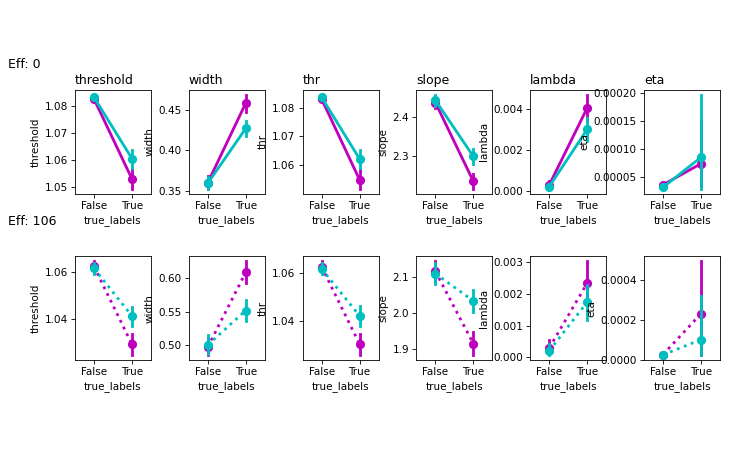

In [258]:
fig, axn = pl.subplots(2, len(parnames), figsize=(10,6))

for pi, par in enumerate(parnames):
    ax=axn[0, pi]
    sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==0].dropna(), 
                 palette=arousal_colors, linestyles='-', ax=ax)
    ax.set_title(par, loc='left')
#     if par in ['threshold', 'thr']:
#         ax.set_ylim([0, 106])
    ax.legend_.remove()
    
    ax=axn[1, pi]
    sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==106].dropna(), 
                 palette=arousal_colors, linestyles=':', ax=ax)
    
    ax.legend_.remove()
fig.text(0.01, 0.85, 'Eff: 0', fontsize=12)
fig.text(0.01, 0.5, 'Eff: 106', fontsize=12)

pl.subplots_adjust(left=0.1, right=0.96, bottom=0.2, top=0.8, wspace=0.5, hspace=0.6)

In [126]:
# sig = 'gauss'
# f_=[]
# for (va, dk, ci, eff, ar, tru), fpars in onefit.groupby(['visual_area', 'datakey', 'cell', 'Eff', 'arousal', 'true_labels']):
#     # Get current sigmoid
#     opts = default_options()
#     eff = int(fpars['Eff'].unique())
#     opts['sigmoidName'] = 'neg_%s' % sig if eff==0 else sig
#     fh = getSig.getSigmoidHandle(opts)
    
#     # interpolate points
#     fvs = fpars.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#                 .apply(get_fit_values, fh, xmin=0, xmax=106, npoints=50).reset_index(drop=True)
#     fvs['arousal'] = ar
#     fvs['true_labels'] = tru
#     fvs['Eff'] = eff
#     f_.append(fvs)
    
print(allow_negative)
opts = p3.default_options()
f_=[]
for (va, dk, ci, sz, arous, tru), g in onefit.groupby(['visual_area', 'datakey', 'cell', 'size',
                                          'arousal', 'true_labels']):
    eff = int(g['Eff'].unique())
    opts['sigmoidName'] = 'neg_%s' % sigmoid if (eff==0 and allow_negative) else sigmoid
    fh = getSig.getSigmoidHandle(opts)
    fvs = p3.get_fit_values(g, fh, xmin=0, xmax=1, npoints=50)
    fvs['arousal'] = arous
    fvs['true_labels'] = tru
    fvs['Eff'] = eff
    
    f_.append(fvs)
    
fitvs = pd.concat(f_)

False


In [127]:
FITY = pd.concat(f_)
FITY.head()

x  fitv visual_area              datakey  cell  size  Eff arousal  \
0  0.000000   0.5          Li  20190316_JC070_fov1    29  10.0  106    high   
1  0.020408   0.5          Li  20190316_JC070_fov1    29  10.0  106    high   
2  0.040816   0.5          Li  20190316_JC070_fov1    29  10.0  106    high   
3  0.061224   0.5          Li  20190316_JC070_fov1    29  10.0  106    high   
4  0.081633   0.5          Li  20190316_JC070_fov1    29  10.0  106    high   

   true_labels  
0        False  
1        False  
2        False  
3        False  
4        False

In [128]:
FITY[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                12
Lm                13
V1                11

In [308]:
curr_dst_dir = os.path.join(dst_dir,'split_pupil', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse/split_pupil/examples


In [132]:
import matplotlib.patches as patches

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


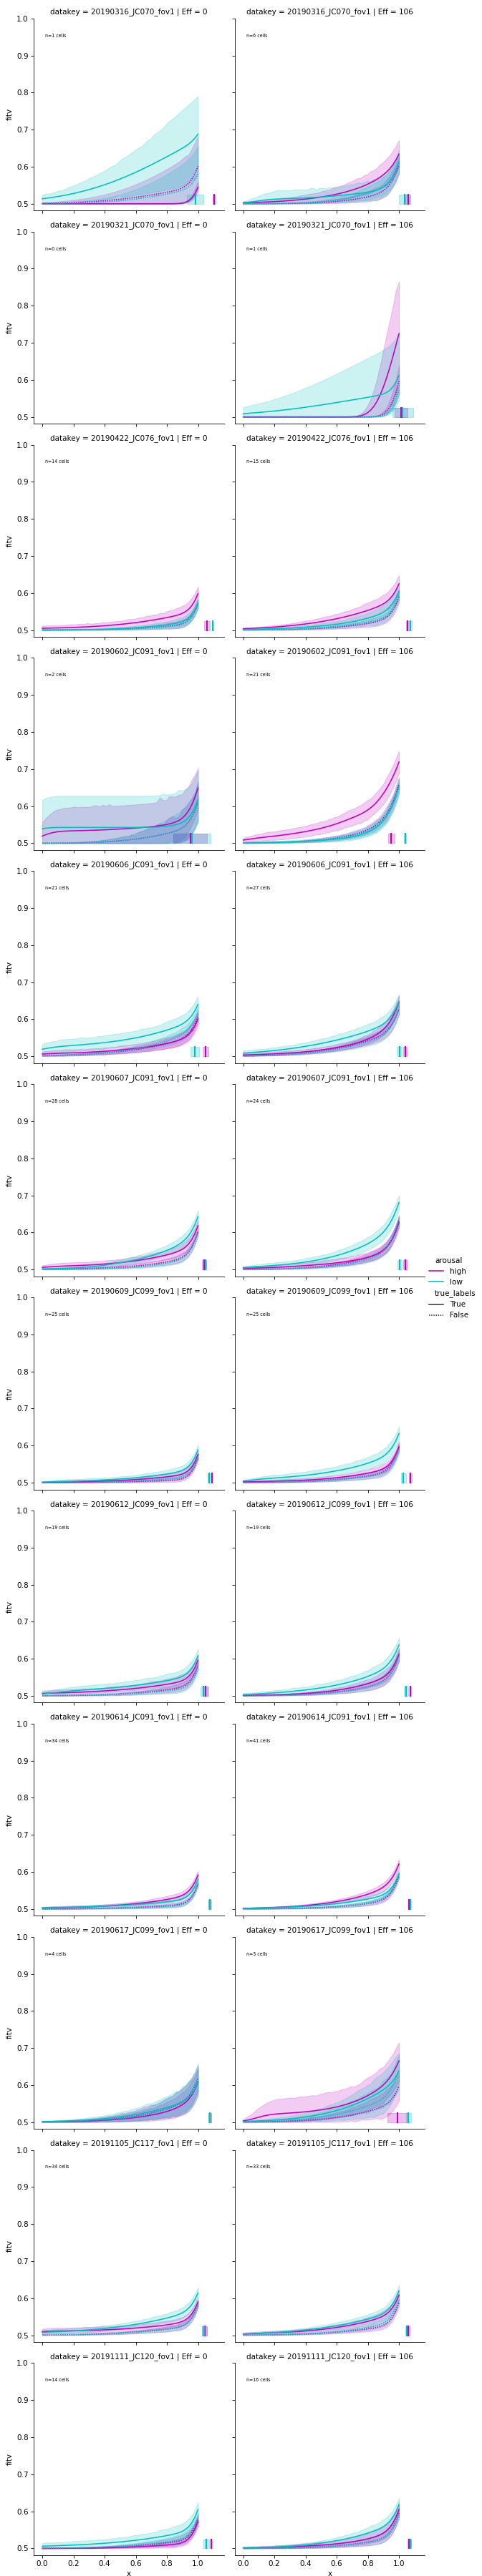

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


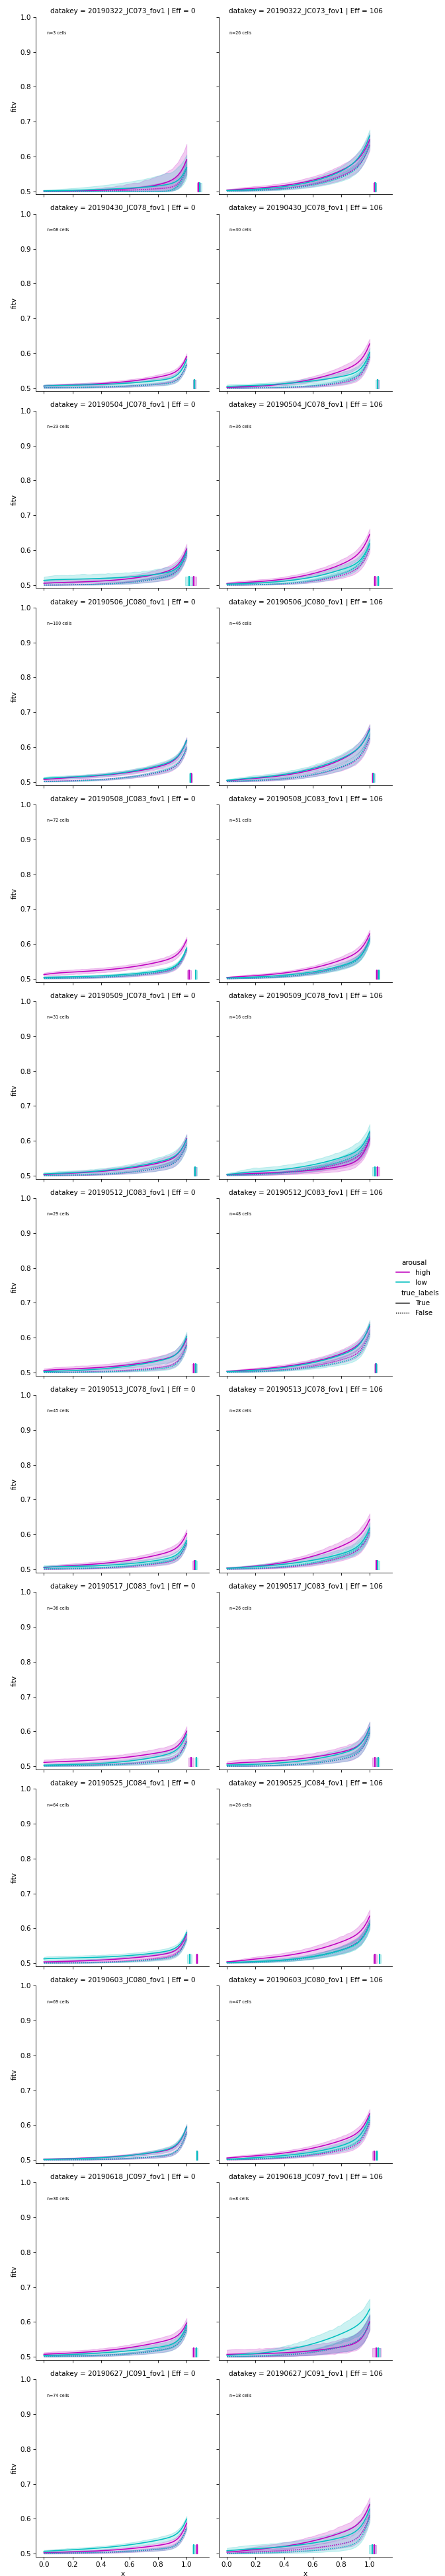

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


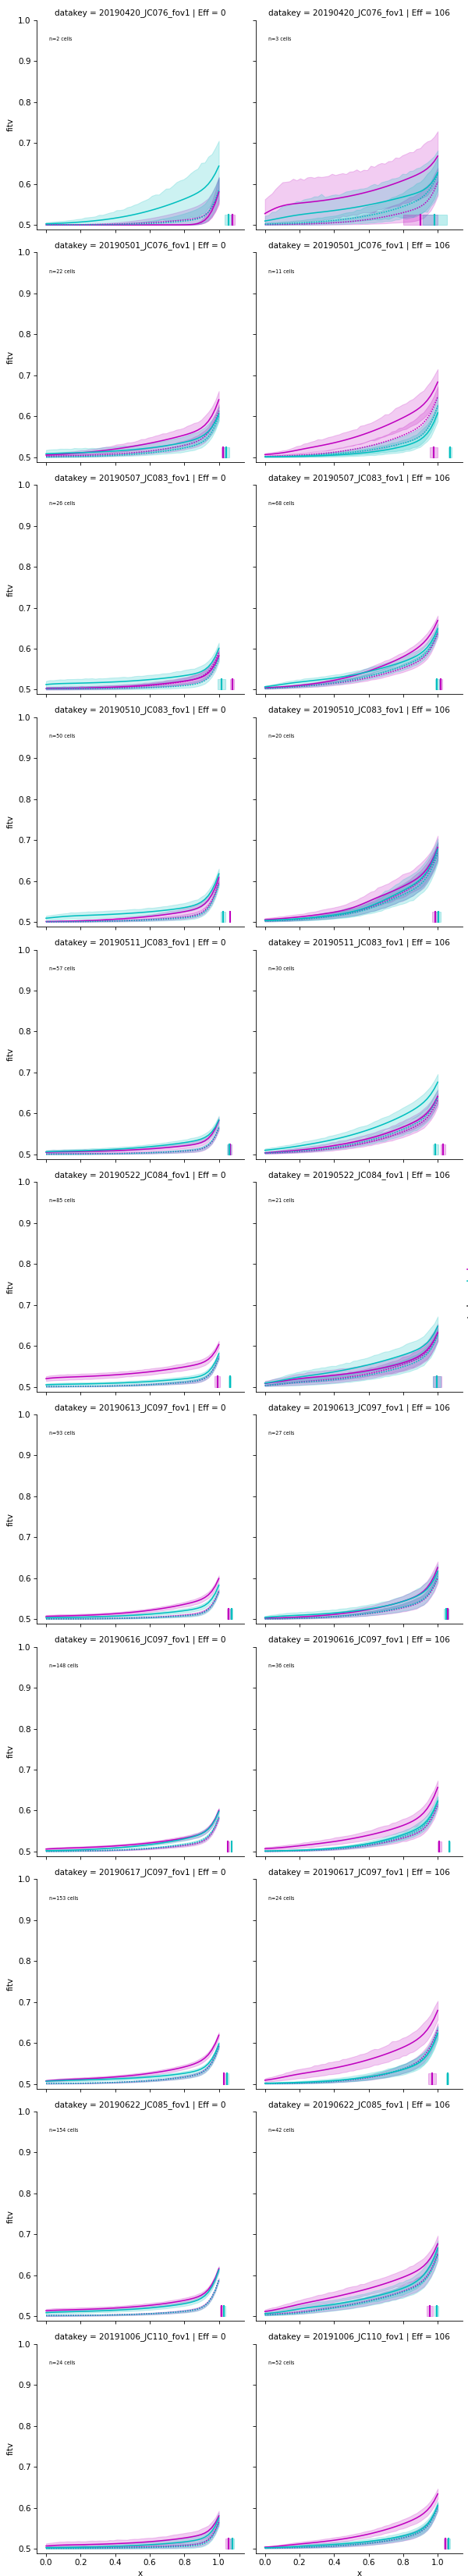

In [133]:
va = 'V1'
dk = '20191006_JC110_fov1'

#for dk in 
#fv = FITY[(FITY.visual_area==va) & (FITY.datakey==dk)].copy()
for va, fv in FITY.groupby(['visual_area']):
#fv = FITY[(FITY.visual_area==va)].copy()

    fg = sns.relplot(x='x', y='fitv', data=fv, ax=ax,
                 hue='arousal', palette=arousal_colors, 
                style='true_labels', dashes=dashes, style_order=[True, False],
                col='Eff', row='datakey', kind='line', height=4, )
    #pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
    #ncells = len(fv['cell'].unique())

    H = 0.525
    ymin = 0.5
    for (dk, eff), ax in fg.axes_dict.items():
        fpars = onefit[(onefit.visual_area==va) & (onefit.datakey==dk) & (onefit['Eff']==eff)]
        ncells = len(fpars['cell'].unique())
        ax.text(0.02, 0.95, 'n=%i cells' % ncells, fontsize=6)
        
        ax.set_ylim([ax.get_ylim()[0], 1])
        try:
            mean_thr = fpars[(fpars['Eff']==eff) & (fpars.true_labels)].groupby(['arousal']).mean()
            sem_thr = fpars[(fpars['Eff']==eff) & (fpars.true_labels)].groupby(['arousal']).sem()
            for a_ in ['high', 'low']:
                thr_hi = mean_thr.loc[a_]['threshold']
                sd_hi = sem_thr.loc[a_]['threshold']
                ax.plot([thr_hi, thr_hi], [ymin, H], color=arousal_colors[a_], lw=2)

                ax.add_patch(patches.Rectangle(
                    xy=(thr_hi-sd_hi, ymin),  # point of origin.
                    width=sd_hi*2.,
                    height=H-ymin,
                    linewidth=1,
                    color=arousal_colors[a_],
                    fill=True, alpha=0.25) )
        except Exception as e:
            continue

    figname = 'avg_curves_%s' % (va)
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [189]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples'

In [184]:
mean_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).mean()
mean_thr.loc['high', False]['threshold']

NameError: name 'fpars' is not defined

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


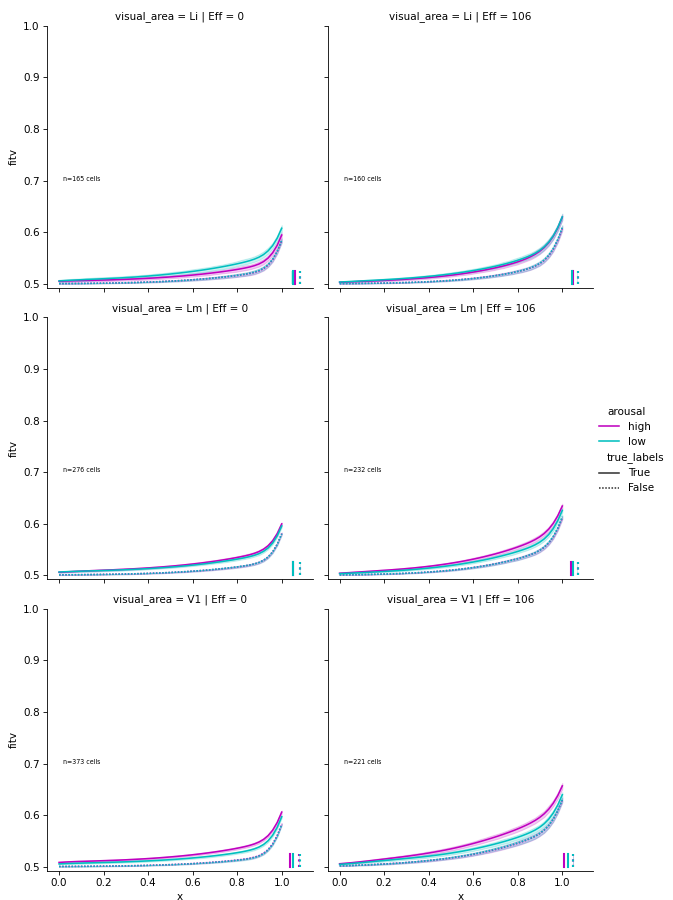

high True 1.0587994469129605 0.004908893992484034
high False 1.0818038776941359 0.0011234779391275074
low True 1.0486036324295906 0.00534163676117659
low False 1.0820569090525365 0.001031730920996169
high True 1.0477632498050204 0.0036978976573999564
high False 1.069568061693179 0.001266782010071304
low True 1.042997766044882 0.0037836082896365707
low False 1.0688197168428055 0.00130461353837054
high True 1.0506246009358013 0.0032035674401734507
high False 1.0831379514500068 0.0012127528501670632
low True 1.0508714672787574 0.003312823853733937
low False 1.0836391591115018 0.001131652426816417
high True 1.0395326698214642 0.003190671155442732
high False 1.0704442620946693 0.001170824369972898
low True 1.049605529878785 0.002763180278459149
low False 1.069316377553336 0.001183260736109415
high True 1.0367823532083342 0.0032857249177004303
high False 1.0793029226572115 0.0010396590102058618
low True 1.0524898231925925 0.002698500453557254
low False 1.0811658898513834 0.000856442703764261

In [134]:
#va='V1'
#for va, fv in FITY.groupby(['visual_area']):
#fv = FITY[(FITY.visual_area==va)].copy()

fg = sns.relplot(x='x', y='fitv', data=FITY, ax=ax,
             hue='arousal', palette=arousal_colors, 
            style='true_labels', dashes=dashes, style_order=[True, False],
            col='Eff', row='visual_area', kind='line', height=4, )

# ncells = len(fv[['datakey', 'cell']].drop_duplicates())

H = 0.525
ymin = 0.5
for (va, eff), ax in fg.axes_dict.items():
    fpars = onefit[(onefit.visual_area==va) & (onefit['Eff']==eff)]
    ncells = len(fpars['cell'].unique())
    ax.text(0.02, 0.7, 'n=%i cells' % ncells, fontsize=6)
    ax.set_ylim([ax.get_ylim()[0], 1])
    try:
        mean_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).mean()
        sem_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).sem()
        for a_ in ['high', 'low']:
            for s_ in [True, False]:
                thr_hi = mean_thr.loc[a_, s_]['threshold']
                sd_hi = sem_thr.loc[a_, s_]['threshold']
                print(a_, s_, thr_hi, sd_hi)
                ls='-' if s_ else ':'
                ax.plot([thr_hi, thr_hi], [ymin, H], color=arousal_colors[a_], lw=2, linestyle=ls)
                ax.add_patch(patches.Rectangle(
                    xy=(thr_hi-sd_hi, ymin),  # point of origin.
                    width=sd_hi*2., height=H-ymin,
                    linewidth=0, color=arousal_colors[a_], fill=True, alpha=0.2) )
    except Exception as e:
        continue
        
figname = 'avg_curves_aggr_cells'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))



In [147]:
fitpars = onefit.copy().reset_index(drop=True)
fitpars.shape

(52620, 14)

In [173]:
fitpars = pd.concat([g for (va, dk, c), g in onefit.groupby(['visual_area', 'datakey', 'cell'])
                 if (g[(g.true_labels)]['threshold'].mean()>=0)
                     & (g[(g.true_labels)]['threshold'].mean()<=1) ])


In [174]:
if allow_negative:
    fitpars['thr_dist'] = None
    fitpars['thr_dist_abs'] = None

    for eff, g in fitpars.groupby(['Eff']):
        fitpars.loc[g.index, 'thr_dist'] = g['threshold'] - eff

    fitpars['thr_dist_abs'] = fitpars['thr_dist'].abs()
    fitpars['abs_slope'] = fitpars['slope'].abs()

In [175]:
# for (va, dk, c), g in onefit.groupby(['visual_area', 'datakey', 'cell']):
#     if g[(g.true_labels) & (g['threshold']<=1) & (g['threshold']>=0)].shape[0]>0:
#         print(g[(g.true_labels) & (g['threshold']<=1) & (g['threshold']>=0)])

<IPython.core.display.Javascript object>


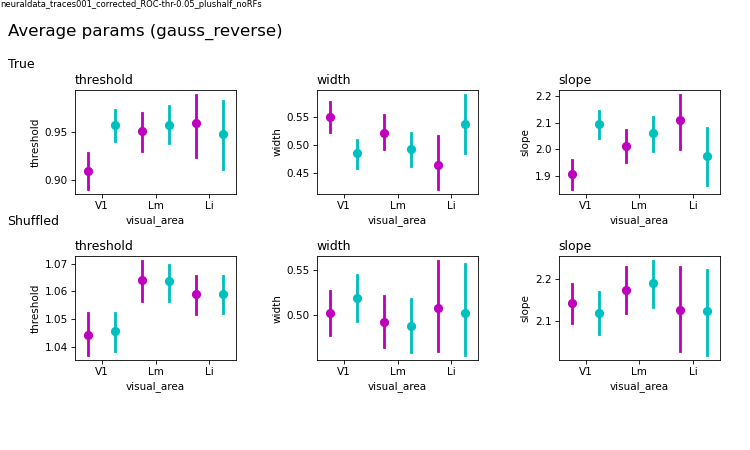

In [176]:
par = 'threshold'
fig, axn = pl.subplots(2, 3, figsize=(10,6))
for pi, par in enumerate(['threshold', 'width', 'slope']):
    ax=axn[0, pi]
    sns.pointplot(x='visual_area', y=par, hue='arousal', data=fitpars[fitpars.true_labels],
                 palette=arousal_colors, linestyles='-', ax=ax, dodge=0.5, size=3, join=False,
                 order=visual_areas)
    ax.set_title(par, loc='left')
    ax.legend_.remove()

    ax=axn[1, pi]
    sns.pointplot(x='visual_area', y=par, hue='arousal', data=fitpars[~fitpars.true_labels],
                 palette=arousal_colors, linestyles='-', ax=ax, dodge=0.5, size=3, join=False,
                  order=visual_areas)
    ax.set_title(par, loc='left')

    ax.legend_.remove()
    
#     ax=axn[1, pi]
#     sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==106].dropna(), 
#                  palette=arousal_colors, linestyles=':', ax=ax)
    
#     ax.legend_.remove()
fig.text(0.01, 0.85, 'True', fontsize=12)
fig.text(0.01, 0.5, 'Shuffled', fontsize=12)

pl.subplots_adjust(left=0.1, right=0.96, bottom=0.2, top=0.8, wspace=0.5, hspace=0.6)

p3.label_figure(fig, data_id)
fig.text(0.01, 0.92, 'Average params (%s)' % sigmoid_dir, fontsize=16)


figname = 'avg_params_by_arousal_shuffcond'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


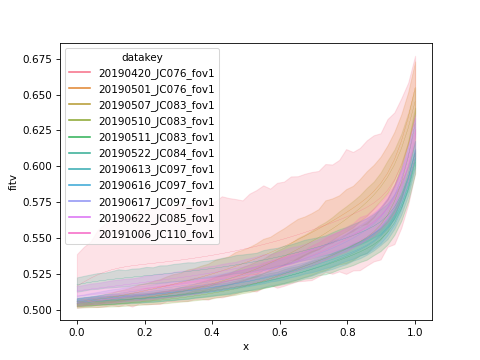

<AxesSubplot:xlabel='x', ylabel='fitv'>

In [180]:
fv = FITY[(FITY.visual_area=='V1')].copy()
m_ = fv.groupby(['datakey', 'cell','arousal', 'true_labels']).mean().reset_indexc()

fig, ax = pl.subplots()
#for (dk, c), g in fv.groupby(['datakey', 'cell']):
sns.lineplot(x='x', y='fitv', hue='datakey', data=m_[(m_.true_labels) & (m_.arousal=='high')], ax=ax,
              color='k', lw=0.2)

In [ ]:

fg = sns.relplot(x='x', y='fitv', data=FITY, ax=ax,
             hue='arousal', palette=arousal_colors, 
            style='true_labels', dashes=dashes, style_order=[True, False],
            col='Eff', row='visual_area', kind='line', height=4, )

# ncells = len(fv[['datakey', 'cell']].drop_duplicates())

H = 0.525
ymin = 0.5
for (va, eff), ax in fg.axes_dict.items():
    fpars = onefit[(onefit.visual_area==va) & (onefit['Eff']==eff)]
    ncells = len(fpars['cell'].unique())
    ax.text(0.02, 0.7, 'n=%i cells' % ncells, fontsize=6)
    ax.set_ylim([ax.get_ylim()[0], 1])
    try:
        mean_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).mean()
        sem_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).sem()
        for a_ in ['high', 'low']:
            for s_ in [True, False]:
                thr_hi = mean_thr.loc[a_, s_]['threshold']
                sd_hi = sem_thr.loc[a_, s_]['threshold']
                print(a_, s_, thr_hi, sd_hi)
                ls='-' if s_ else ':'
                ax.plot([thr_hi, thr_hi], [ymin, H], color=arousal_colors[a_], lw=2, linestyle=ls)
                ax.add_patch(patches.Rectangle(
                    xy=(thr_hi-sd_hi, ymin),  # point of origin.
                    width=sd_hi*2., height=H-ymin,
                    linewidth=0, color=arousal_colors[a_], fill=True, alpha=0.2) )
    except Exception as e:
        continue

In [275]:
import pingouin as pg

In [ ]:
pvals = reject, pvals_corr = pg.multicomp(pvals, method='fdr_bh')

In [ ]:
x = fitpars[fitpars.true_labels]
spstats.mannwhitneyu(x, y)


In [280]:
fitpars['visual_area'] = fitpars['visual_area'].astype('category')
fitpars['arousal'] = fitpars['arousal'].astype('category')

fitpars.dtypes

threshold        float64
width            float64
lambda           float64
gamma            float64
eta              float64
slope            float64
thr               object
visual_area     category
datakey           object
cell               int64
size             float64
Eff                int64
arousal         category
true_labels         bool
thr_dist          object
thr_dist_abs      object
dtype: object

In [286]:
# aov = pg.mixed_anova(data=fitpars[fitpars.true_labels], 
#                      dv='threshold', within='arousal', between='visual_area')

aov = pg.anova(data=fitpars[fitpars.true_labels], 
                     dv='threshold',between=['visual_area', 'arousal'])

In [290]:
aov2 = pg.anova(data=fitpars[~fitpars.true_labels], 
                     dv='threshold',between=['visual_area', 'arousal'])
aov2.round(3)

Source            SS      DF         MS       F  p-unc  \
0            visual_area  8.720057e+04     2.0  43600.287  16.377   0.00   
1                arousal  4.382581e+03     1.0   4382.581   1.646   0.20   
2  visual_area * arousal  1.609210e+02     2.0     80.461   0.030   0.97   
3               Residual  1.313065e+07  4932.0   2662.337     NaN    NaN   

     np2  
0  0.007  
1  0.000  
2  0.000  
3    NaN

In [292]:
aov.round(3)

Source           SS      DF         MS       F  p-unc    np2
0            visual_area    87236.852     2.0  43618.426  21.747  0.000  0.014
1                arousal     1379.830     1.0   1379.830   0.688  0.407  0.000
2  visual_area * arousal     5944.927     2.0   2972.464   1.482  0.227  0.001
3               Residual  6366235.852  3174.0   2005.745     NaN    NaN    NaN

In [287]:
pg.__version__

'0.3.10'

# Example cells

In [94]:
va='V1'
curr_datakey ='20190507_JC083_fov1'

traceid_dir = p3.get_tracedir_from_datakey(curr_datakey)

auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'mean_aucs_single.pkl'))[0]
with open(auc_outfile, 'rb') as f:
    auc_fov = pkl.load(f)
    

In [309]:
curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

curr_id = '%s|%s|%s' % (data_id, va, dk)
print(curr_id)

/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/neurometric/split_pupil/examples
neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs|V1|20190507_JC083_fov1


In [310]:
### 1 cell, AUC:
rid=8
auc_r = auc_fov[auc_fov['cell']==rid]
auc_r.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
1080          V1  20190507_JC083_fov1     8    high        False           0   
1081          V1  20190507_JC083_fov1     8    high        False           0   
1082          V1  20190507_JC083_fov1     8    high        False           0   
1083          V1  20190507_JC083_fov1     8    high        False           0   
1084          V1  20190507_JC083_fov1     8    high        False           0   

      size  Eff  index       AUC  n_trials  iteration  n_chooseB  
1080  10.0  106   40.0  0.566250       5.0       49.5   2.831250  
1081  20.0  106   41.0  0.488333       7.0       49.5   3.418333  
1082  30.0  106   42.0  0.563333       7.0       49.5   3.943333  
1083  40.0  106   43.0  0.506111       7.0       49.5   3.542778  
1084  50.0  106   44.0  0.502500       5.0       49.5   2.512500

In [311]:
data_id

'neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs'

<IPython.core.display.Javascript object>


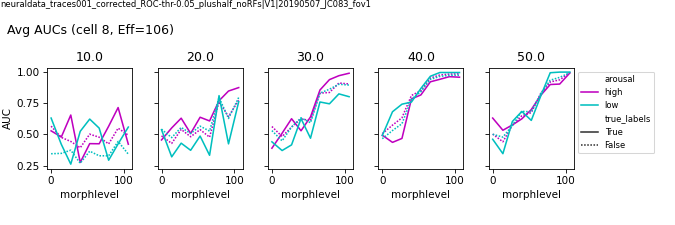

/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/neurometric/split_pupil/examples V1_20190507_JC083_fov1_rid008_auc
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse V1_20190507_JC083_fov1_rid008_auc


In [312]:
sizes= sorted(auc_r['size'].unique())
eff = int(auc_r['Eff'].unique())

fig, axn = pl.subplots(1,len(sizes), figsize=(9,3), sharex=True, sharey=True)
for ax, (sz, sg) in zip(axn.flat, auc_r[auc_r['Eff']==eff].groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax,
                style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)

axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=8)

fig.text(0.01, 0.85, 'Avg AUCs (cell %i, Eff=%i)' % (rid, eff), fontsize=12)
pl.subplots_adjust(left=0.07, right=0.85, bottom=0.25, top=0.7, wspace=0.3)
p3.label_figure(fig, curr_id)

figname = '%s_%s_rid%03d_auc' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(dst_dir, 'split_pupil', 'examples', '%s.svg' % figname))
print(dst_dir, figname)


In [342]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

# Tets plotting from params

In [343]:
importlib.reload(ps)

<module 'psignifit' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/__init__.py'>

In [344]:
# fiter = auc_r.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#         .apply(group_fit_psignifit, opts, allow_negative=allow_negative)



In [102]:
# fit_params = ['threshold', 'width', 'lambda', 'gamma','eta']
# fit, = curr_fparams[fit_params].values

# alpha = options['widthalpha']
# sigmoid = options['sigmoidName']
# PC = options['threshPC']       
sig='gauss'
opts = p3.default_options()
opts['sigmoidName'] = 'neg_%s' % sig if (eff==0 & allow_negative) else sig
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)
opts['widthalpha'] = .05


In [103]:
import copy

In [104]:
fiter = rfits[(rfits.visual_area==va) & (rfits.datakey==dk) & (rfits['cell']==rid)]


In [112]:
fh = getSig.getSigmoidHandle(opts)

fitvs = fiter.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
            .apply(p3.get_fit_values, fh, xmin=0, xmax=1, npoints=50).reset_index(drop=True)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
port_markers={'high':'o', 'low':'X'}
markers={True:'.', False:'.'}


In [313]:
plot_data=True

#def plot_split_pupil_fits_by_size(auc_r, opts=None, npoints=50, plot_data=True):
port_markers={'high':'o', 'low':'X'}
markers={True:'.', False:'.'}

if opts is None:
    opts = p3.default_options()
fh = getSig.getSigmoidHandle(opts)
fitvs = fiter.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
            .apply(p3.get_fit_values, fh, xmin=0, xmax=1, npoints=npoints).reset_index(drop=True)


fig, axn = pl.subplots(1,len(sizes), figsize=(9,3), sharex=True, sharey=True)
auc_r['morph_ix'] = auc_r['morphlevel']/float(auc_r['morphlevel'].max())
for ax, (sz, fv) in zip(axn.flat, fitvs.groupby(['size'])):
    sns.lineplot(x='x', y='fitv', data=fv, ax=ax,
                hue='arousal', palette=arousal_colors,
                style='true_labels', style_order=[True, False], dashes=dashes)
    
    if plot_data:
        auc_r = auc_r[auc_r['size']==sz]
        sns.lineplot(x='morph_ix', y='AUC', data=auc_r[auc_r.true_labels], ax=ax,
                        hue='arousal', palette=arousal_colors,
                        style='true_labels', style_order=[True, False], dashes=dashes, lw=0.,
                        sizes=[10,10], markers=markers)
    ax.legend_.remove()
    ax.set_title('Sz %i' % sz, loc='left', fontsize=8)

axn[-1].legend(bbox_to_anchor=(1,1.2), loc='upper left')
fig.text(0.01, 0.85, 'Fits (cell %i, Eff=%i)' % (rid, eff), fontsize=12)


pl.subplots_adjust(left=0.07, right=0.85, bottom=0.25, top=0.75, wspace=0.3)
p3.crop_legend_labels(ax, n_hues=6, bbox_to_anchor=(1,1), loc='upper left', fontsize=8)

p3.label_figure(fig, curr_id)


figname = '%s_%s_rid%03d_auc' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(dst_dir, 'split_pupil', 'examples', '%s.svg' % figname))
print(dst_dir, figname)

NameError: name 'npoints' is not defined

In [204]:
arousal_colors={'high': 'm', 'low': 'c'}

sigmoid_ = 'gauss'

fig, axn = pl.subplots(1, 2, figsize=(10,4))

for (a_cond, curr_sz), a_ in auc_r[auc_r['size']==30].groupby(['arousal', 'size',]):
    ai = sizes.index(curr_sz)
    
    ax=axn[0]
    lc = mpl.colors.to_rgb( arousal_colors[a_cond] )
    
    data_ = data_matrix_from_auc(a_[a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    ax=axn[1]
    data_ = data_matrix_from_auc(a_[~a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    fig.text(0.01, 0.95, 'Sz %i (%s)' % (curr_sz, sigmoid_), fontsize=16)
    ax.legend()

array([2.26854062e+01, 3.62768755e+01, 1.15515243e-12, 5.00000000e-01,
       1.09553646e-10])

In [15]:
#### Load AUC 
sigmoid = 'gauss'
param='morphlevel'
allow_negative=True
class_a=0
class_b=106

AUC = load_aggregate_AUC(param=param, reverse_eff=not(allow_negative),
                          selective_only=False, selective_df=None)
    

   cell  level_1  index       AUC  morphlevel  size  n_trials  Eff  \
0    76        0     40  0.548889           0  10.0        30  106   
1    76        1      0  0.484444          14  10.0        30  106   
2    76        2      1  0.372222          27  10.0        30  106   
3    76        3      2  0.457778          40  10.0        30  106   
4    76        4      3  0.401111          53  10.0        30  106   

  visual_area              datakey  
0          Li  20190422_JC076_fov1  
1          Li  20190422_JC076_fov1  
2          Li  20190422_JC076_fov1  
3          Li  20190422_JC076_fov1  
4          Li  20190422_JC076_fov1  


In [16]:
criterion = 0.7

passAUC = AUC[(AUC['morphlevel'].isin([class_a, class_b])) & (AUC['AUC']>=criterion)].copy()


print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(passAUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())



Total N cells fit:
             datakey  cell
visual_area               
Li               451   451
Lm              1061  1061
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               147   147
Lm               342   342
V1               553   553


In [17]:
print(selective_df[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               326   326
Lm               636   636
V1               892   892


In [18]:
selective_only=False
selective_str = 'selective' if selective_only else "allcells"

if selective_only:
    print("... getting SELECTIVE only")
    s_=[]
    for (va, dk), g in passAUC.groupby(['visual_area', 'datakey']):
        curr_cells_auc = g['cell'].unique()

        curr_cells_sel = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        s_.append(g[g['cell'].isin(sel_and_auc)])

    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)

else:
    pSEL = passAUC.copy()
    
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               147   147
Lm               342   342
V1               553   553


In [19]:
ncells_pass = passAUC.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
# ncells_pass

In [20]:
del AUC

<IPython.core.display.Javascript object>


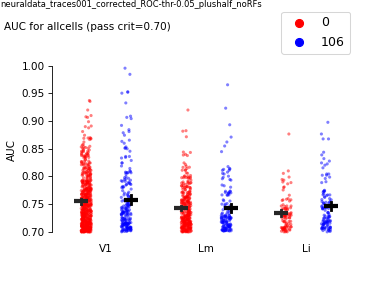

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit auc_allcells-crit-0.70


In [21]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=pSEL, ax=ax, zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)

sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=pSEL, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
             zorder=-1, scale=2)

ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')

fig.text(0.01, 0.9, 'AUC for %s (pass crit=%.2f)' % (selective_str, criterion))

crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)
label_figure(fig, data_id)

figname = 'auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Split arousal trials

In [22]:
fit_cells = pass_estimates[['visual_area', 'datakey', 'cell', 'size']].drop_duplicates()
fit_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

NameError: name 'pass_estimates' is not defined

In [15]:
def decode_analysis_id(visual_area=None, prefix='split_pupil', response_type='dff', responsive_test='ROC',
                       overlap_thr=None, trial_epoch='plushalf', C_str='tuneC'):
    overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap%.2f' % overlap_thr
    results_id = '%s_%s__%s-%s_%s__%s__%s' \
                    % (prefix, visual_area, response_type, responsive_test, overlap_str, trial_epoch, C_str)
    return results_id


In [16]:
def add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs, midp=53):
    # add stimulus info
    morphlevels = sdf['morphlevel'].unique()
    max_morph = max(morphlevels)

    assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)
        
    ndf['size'] = [sdf['size'][c] for c in ndf['config']]
    ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
    ndf = ndf[(ndf['morphlevel']!=-1)].copy()

    morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
    # update neuraldata
    ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
    ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

    ndf['object'] = None
    ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
    ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
    ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'

    return ndf

In [ ]:
decode_prefix='split_pupil'
morph_lut, a_morphs, b_morphs = get_morph_levels()

# 

#### Testing loading AUCs and fitting curve for 1 fov

In [35]:
decode_prefix='split_pupil'
morph_lut, a_morphs, b_morphs = get_morph_levels()

# 
va='V1'
dk='20190616_JC097_fov1'

sdf = SDF[dk].copy()

curr_results_id = decode_analysis_id(visual_area=va, responsive_test=responsive_test,
                       response_type='dff', overlap_str='noRF', trial_epoch='plushalf')
print(curr_results_id)

traceid_dir = get_tracedir_from_datakey(dk)
print(traceid_dir)

split_pupil_V1__dff-ROC_noRF__plushalf__tuneC
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b


In [207]:
glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs'))

['/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/neurometric/aucs']

In [41]:
#### tets loading
auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs', '%s.pkl' % curr_results_id))[0]
with open(auc_outfile, 'rb') as f:
    auc_fov = pkl.load(f)
    

In [56]:
mean_ = auc_fov.groupby(['visual_area', 'datakey', 'cell', 
                         'arousal', 'true_labels', 'morphlevel', 'size']).mean().reset_index()

In [215]:
mean_[mean_['cell']==217]

visual_area              datakey  cell arousal  true_labels  morphlevel  \
17460          V1  20190616_JC097_fov1   217    high        False           0   
17461          V1  20190616_JC097_fov1   217    high        False           0   
17462          V1  20190616_JC097_fov1   217    high        False           0   
17463          V1  20190616_JC097_fov1   217    high        False           0   
17464          V1  20190616_JC097_fov1   217    high        False           0   
...           ...                  ...   ...     ...          ...         ...   
17635          V1  20190616_JC097_fov1   217     low         True         106   
17636          V1  20190616_JC097_fov1   217     low         True         106   
17637          V1  20190616_JC097_fov1   217     low         True         106   
17638          V1  20190616_JC097_fov1   217     low         True         106   
17639          V1  20190616_JC097_fov1   217     low         True         106   

       size  index       AUC  n_trials  Eff  iteration  n_chooseB  
17460  10.0    0.0  0.622000       5.0  0.0       49.5   3.110000  
17461  20.0    8.0  0.629375       8.0  0.0       49.5   5.035000  
17462  30.0   16.0  0.945952       7.0  0.0       49.5   6.621667  
17463  40.0   24.0  0.665500       5.0  0.0       49.5   3.327500  
17464  50.0   32.0  0.497857       7.0  0.0       49.5   3.485000  
...     ...    ...       ...       ...  ...        ...        ...  
17635  10.0   40.0  0.445000       5.0  0.0       49.5   2.225000  
17636  20.0   41.0  0.564063       8.0  0.0       49.5   4.512500  
17637  30.0   42.0  0.533889       7.0  0.0       49.5   3.737222  
17638  40.0   43.0  0.546250       5.0  0.0       49.5   2.731250  
17639  50.0   44.0  0.468333       7.0  0.0       49.5   3.278333  

[180 rows x 13 columns]

In [211]:
mean_.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
0          V1  20190616_JC097_fov1     0    high        False           0   
1          V1  20190616_JC097_fov1     0    high        False           0   
2          V1  20190616_JC097_fov1     0    high        False           0   
3          V1  20190616_JC097_fov1     0    high        False           0   
4          V1  20190616_JC097_fov1     0    high        False           0   

   size  index       AUC  n_trials    Eff  iteration  n_chooseB  
0  10.0  17.20  0.507500       5.0  45.58       49.5   2.537500  
1  20.0  22.19  0.529687       8.0  45.58       49.5   4.237500  
2  30.0  27.18  0.633254       7.0  45.58       49.5   4.432778  
3  40.0  32.17  0.451250       5.0  45.58       49.5   2.256250  
4  50.0  37.16  0.520556       7.0  45.58       49.5   3.643889

In [212]:
len(mean_[mean_['AUC']>=0.7]['cell'].unique())

183

In [79]:
rid=217
auc_r = mean_[mean_['cell']==rid]

In [78]:
arousal_colors={'high': 'm', 'low': 'c'}


<IPython.core.display.Javascript object>


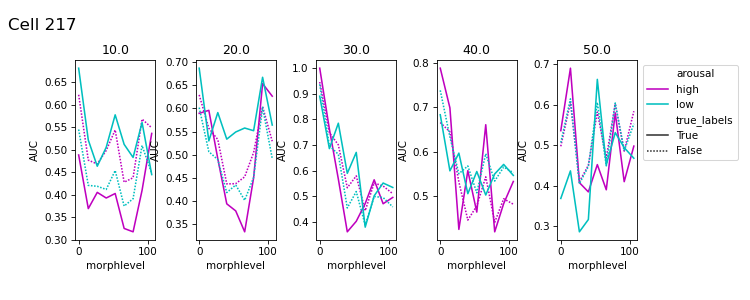

In [69]:
dashes=['', (1, 1)]
        
sizes = sorted(auc_r['size'].unique())

fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r.groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax,
                style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
    
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i' % rid, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [184]:
auc_fov.head()

cell  index  AUC  morphlevel  size  n_trials  Eff arousal  iteration  \
0     0     40 -0.0           0  10.0         5  106    high         91   
1     0      0  0.2          14  10.0         5  106    high         91   
2     0      1  0.7          27  10.0         5  106    high         91   
3     0      2  0.5          40  10.0         5  106    high         91   
4     0      3  0.6          53  10.0         5  106    high         91   

   true_labels  n_chooseB visual_area              datakey  
0        False       -0.0          V1  20190616_JC097_fov1  
1        False        1.0          V1  20190616_JC097_fov1  
2        False        3.5          V1  20190616_JC097_fov1  
3        False        2.5          V1  20190616_JC097_fov1  
4        False        3.0          V1  20190616_JC097_fov1

In [ ]:
auc_fov

In [80]:
auc_iters = auc_fov[(auc_fov['cell']==rid) & (auc_fov['size']==30)].copy()
auc_iters.head()

cell  index       AUC  morphlevel  size  n_trials  Eff arousal  \
4383   217     16  1.000000           0  30.0         7    0    high   
4384   217     17  0.785714          14  30.0         7    0    high   
4385   217     18  0.761905          27  30.0         7    0    high   
4386   217     19  0.583333          40  30.0         6    0    high   
4387   217     20  0.833333          53  30.0         7    0    high   

      iteration  true_labels  n_chooseB visual_area              datakey  
4383         91        False   7.000000          V1  20190616_JC097_fov1  
4384         91        False   5.500000          V1  20190616_JC097_fov1  
4385         91        False   5.333333          V1  20190616_JC097_fov1  
4386         91        False   3.500000          V1  20190616_JC097_fov1  
4387         91        False   5.833333          V1  20190616_JC097_fov1

# test 1 cell/fov

## Load split trial input data

#### test 1 animal

In [71]:
va='V1'
dk = '20190616_JC097_fov1'
midp=53

In [72]:

nd = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
# get selective cells
seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
sel_cells = seldf['cell'].unique().astype(int)

# add stimulus info
sdf = SDF[dk].copy()
morphlevels = sdf['morphlevel'].unique()
sizes = list(sdf['size'].unique())
if midp not in morphlevels:
    print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
nd['size'] = [sdf['size'][c] for c in nd['config']]
nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# update neuraldata
ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
ndf['object'] = None
ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [73]:
ndf['cell'].unique()[0:20]

array([ 0, 11, 15, 17, 23, 24, 25, 30, 34, 37, 38, 45, 49, 50, 54, 55, 63,
       64, 65, 67])

In [74]:
sig='gauss'

class_a=0
class_b=106
include_ref=True
n_crit=20

rid = 217 #65 #217 #90 #217
assert rid in ndf['cell'].unique()
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=True)

sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
print(sigmoid_)

neg_gauss


In [75]:
aucs = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=False)


In [76]:
p_fas[sizes.index(sz), :].shape

(50,)

In [25]:
rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['size', 'object']).mean()

trial   cell     response     baseline  morphlevel  \
size object                                                            
10.0 A       751.500000  217.0  1052.702325  1058.698149         0.0   
     B       749.800000  217.0  1051.263547  1062.372133       106.0   
20.0 A       758.033333  217.0  1081.734422  1054.741704         0.0   
     B       749.000000  217.0  1062.288977  1061.472593       106.0   
30.0 A       750.200000  217.0  1209.596380  1053.868328         0.0   
     B       749.800000  217.0  1084.772630  1059.755824       106.0   
40.0 A       752.033333  217.0  1192.000941  1051.891997         0.0   
     B       747.533333  217.0  1140.123545  1058.635893       106.0   
50.0 A       753.033333  217.0  1158.717556  1055.745936         0.0   
     B       749.733333  217.0  1162.798059  1058.251049       106.0   

             morphstep  morph_ix  
size object                       
10.0 A             4.0       0.0  
     B             4.0       1.0  
20.0 A             4.0       0.0  
     B             4.0       1.0  
30.0 A             4.0       0.0  
     B             4.0       1.0  
40.0 A             4.0       0.0  
     B             4.0       1.0  
50.0 A             4.0       0.0  
     B             4.0       1.0

<IPython.core.display.Javascript object>


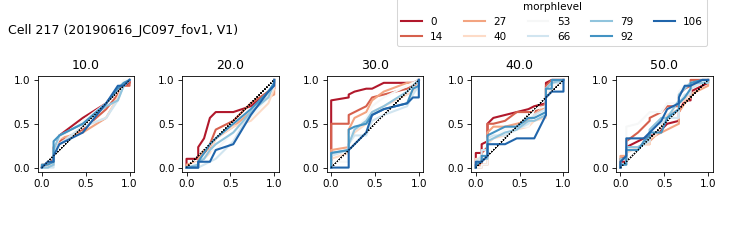

Text(0.01, 0.85, 'Cell 217 (20190616_JC097_fov1, V1)')

In [78]:
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [29]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [79]:
# aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=True)

curr_sz=30
auc_ = aucs[aucs['size']==curr_sz].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 28.        , 30.        ],
       [ 0.13207547, 24.        , 30.        ],
       [ 0.25471698, 23.        , 30.        ],
       [ 0.37735849, 20.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 19.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 20.        , 30.        ],
       [ 1.        , 21.        , 30.        ]])

<IPython.core.display.Javascript object>


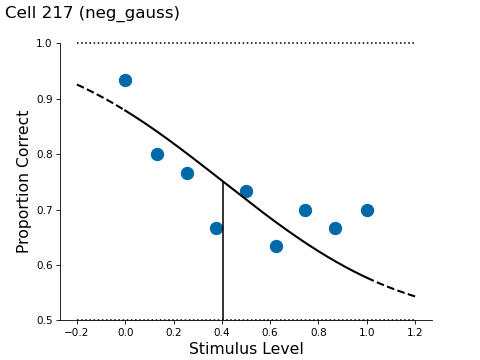

(array([], dtype=int64),)
[0.41 1.92 0.   0.5  0.  ]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


Text(0.01, 0.95, 'Cell 217 (neg_gauss)')

In [82]:
fig, ax = pl.subplots()
ni = 0
opts = dict()
opts['sigmoidName'] = sigmoid_

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
res_ = ps.psignifit(data_, opts)
print(res_['Fit'].round(2))
# norm: [0.74 1.27 0.   0.5  0.  ]
# gumbel: [0.76 1.18 0.   0.5  0.  ]
# neg_gumbel: [0.16 0.69 0.   0.5  0.  ]

# Weibull: [0.88 0.5  0.   0.5  0.  ]
# [0.78 0.91 0.   0.5  0.  ]
thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                             lineColor='k', label=info_str)
fig.text(0.01, 0.95, 'Cell %i (%s)' % (rid, sigmoid_), fontsize=16)

## Fit by size - test 1 cell

In [32]:
cols = sns.color_palette('plasma', n_colors=5)
size_colors = dict((k, v) for k, v in zip(sizes, cols))

In [91]:
va='V1'
dk = '20190616_JC097_fov1'

aucs = mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk)].copy()
# aucs = mAUC[(mAUC.visual_area==va)].copy()

aucs.head()
print(aucs.shape)

(8280, 9)


In [92]:
max_auc=0.7
pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()

101 of 184 cells pass crit (0.70)


In [113]:
best_config_only=False

if best_config_only:
    # Best config (size) for each cell
    max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
    best_sz_per_cell = [(r, c) for (r, c), g in pass_auc[max_auc_ixs].groupby(['cell', 'size'])]
    assert len(pass_cells)==len(best_sz_per_cell)
    best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])
else:
    best_auc = pass_auc.copy()
    
best_auc.head()


cell  level_1       AUC  morphlevel  size  n_trials  Eff visual_area  \
95535     9        0  0.555556           0  10.0        30    0          V1   
95536     9        1  0.481111          14  10.0        30    0          V1   
95537     9        2  0.508889          27  10.0        30    0          V1   
95538     9        3  0.555556          40  10.0        30    0          V1   
95539     9        4  0.494444          53  10.0        30    0          V1   

                   datakey  
95535  20190616_JC097_fov1  
95536  20190616_JC097_fov1  
95537  20190616_JC097_fov1  
95538  20190616_JC097_fov1  
95539  20190616_JC097_fov1

# Stimuli

In [186]:
importlib.reload(p3)


<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [187]:
curr_dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves', 'stimuli')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)

In [188]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [189]:
morph_lut, a_morphs, b_morphs = p3.get_morph_levels()


In [190]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [191]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

In [195]:
morph_ims = [i for i in sorted(morphlevels) if i!=-1]


<IPython.core.display.Javascript object>


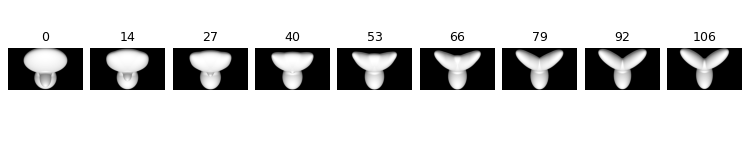

In [206]:
fig, axn = pl.subplots(1,len(morph_ims), figsize=(10,2))
for ax, m in zip(axn.flat, morph_ims):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

    pl.subplots_adjust(left=0.01, right=0.99, bottom=0.2, wspace=0.1)
pl.savefig(os.path.join(curr_dst_dir, 'morph_levels.svg'))


<IPython.core.display.Javascript object>


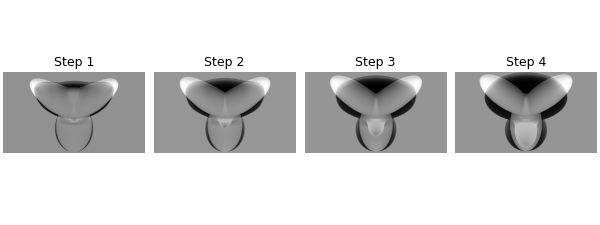

In [236]:

fig, axn = pl.subplots(1, 4, figsize=(8,3), constrained_layout=True)
diffs = {}
sumd=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    sumd.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


pl.savefig(os.path.join(curr_dst_dir, 'morph_steps.svg'))


In [237]:
lindiffs=[]
xlabels=[]
for mi, m in enumerate(morph_ims):
    if mi==0:
        continue
    im1 = images[m]
    m2 = mi if mi==0 else mi-1
    im2 = images[morph_ims[m2]]
    print(morph_ims[mi], morph_ims[m2])
    
    curr_ediff = sp.spatial.distance.euclidean( im1.ravel(), im2.ravel())
    
    lindiffs.append(curr_ediff)
    xlabels.append('[m%i-m%i]' % (morph_ims[mi], morph_ims[m2]))


14 0
27 14
40 27
53 40
66 53
79 66
92 79
106 92


<IPython.core.display.Javascript object>


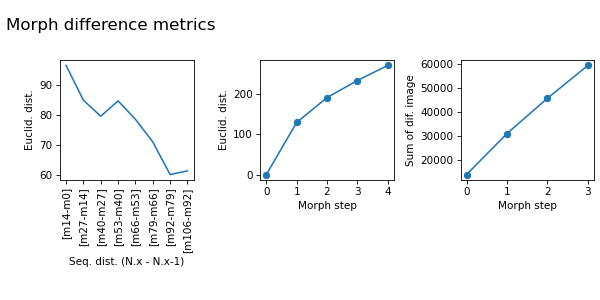

In [245]:
fig, axn = pl.subplots(1,3, figsize=(8,4))

ax=axn[0]
ax.plot(lindiffs)
ax.set_xticks(range(len(lindiffs)))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel('Seq. dist. (N.x - N.x-1)')
ax.set_ylabel('Euclid. dist.')


ax=axn[1]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xticks(range(len(morphsteps)))
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[2]
ax.plot(sumd, marker='o')
ax.set_xticks(range(len(sumd)))

ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.1, right=0.99, bottom=0.4, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, 'Morph difference metrics', fontsize=16)



pl.savefig(os.path.join(curr_dst_dir, 'morph_diffs.svg'))


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

In [324]:
opts = dict()
opts['sigmoidName'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
res = ps.psignifit(data, opts)


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

<IPython.core.display.Javascript object>


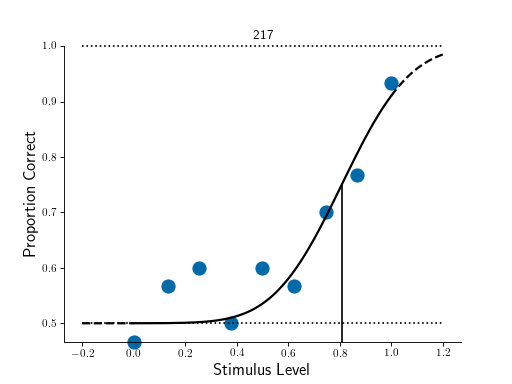

Text(0.5, 1.0, '217')

In [326]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(rid)


In [333]:
ps.getThreshold(res, 0.75)


(0.807906798155016,
 array([[0.57525885, 1.44231971],
        [0.6195629 , 1.24934457],
        [0.69767686, 1.00144201]]))

In [335]:
ps.getThreshold(res, 0.75, 1)

(0.9490430475764219,
 array([[0.63759465, 1.35223187],
        [0.69325121, 1.27614412],
        [0.80064194, 1.13613742]]))

In [334]:
ps.getSlope(res, 0.75)


0.9174598161274641

In [247]:
res['options']['sigmoidHandle']

<function psignifit.getSigmoidHandle.getSigmoidHandle.<locals>.<lambda>(X, m, width)>

<IPython.core.display.Javascript object>


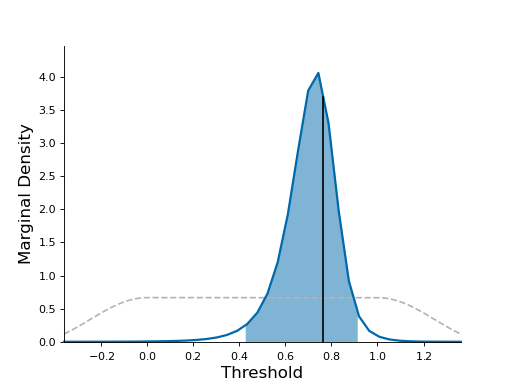

In [28]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

pi = 0
par = param_names[pi]
fig, ax = pl.subplots()

ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)


<IPython.core.display.Javascript object>


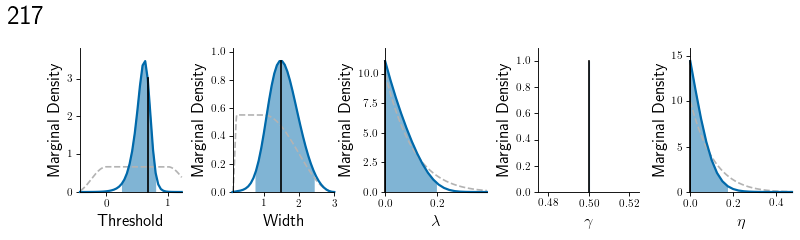

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:324: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '217')

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


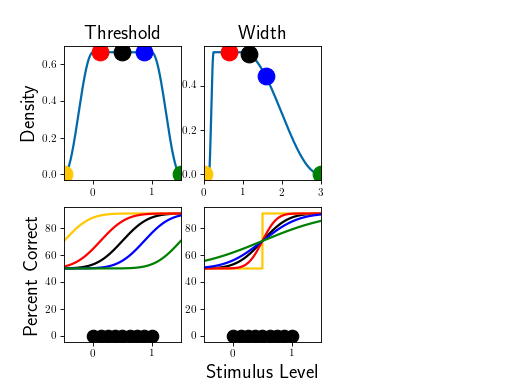

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)

# Goodness of fit

In [35]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(pPred, sr)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals

def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [36]:
d_resid, d, samples_d_resid, samples_d, r_vals = getDeviance(res_, Nsamples=5000)
d_resid.shape, d.shape, samples_d_resid.shape, samples_d.shape
assert d == np.sum(d_resid**2)
print(d)

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


3.878576649067748


In [38]:
fit = res_['Fit']
data = res_['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res_['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

In [40]:
col='gray'
fig,axn=pl.subplots(1,3, figsize=(8,3))
ax=axn[0]
sns.histplot(data=samples_d, ax=ax, color=col)
ax.axvline(x=d, color='r')
ax.set_xlabel('deviance')
ci_lo_sampled, ci_hi_sampled = get_empirical_ci(samples_d)
for ci in [ci_lo_sampled, ci_hi_sampled]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.text(ci_lo_sampled-2, -30, round(ci_lo_sampled, 2), color='r')
ax.set_title('D=%.2f' % d, loc='left')

ax=axn[1]
ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
ax.legend()
ax.set_xlabel('prediction')
ax.set_ylabel('deviance residuals')
ax.axhline(y=0.5, color='gray')

ax=axn[2]
sns.histplot(data=r_vals, ax=ax, color=col)
ax.axvline(x=data_r, color='r')
for ci in [ci_lo, ci_hi]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.set_xlabel('model prediction, r')

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

figname = 'deviance_%s' % animalid
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


<IPython.core.display.Javascript object>

NameError: name 'animalid' is not defined

In [283]:
min(r_vals)

-0.9417343157475857